https://towardsdatascience.com/creating-fake-maps-with-gans-42ad1fc94d97

https://github.com/FrankRuns/fake-maps

https://github.com/t0nberryking/DCGAN256

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from math import floor

from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Dense, AveragePooling2D, GaussianNoise
from keras.layers import Reshape, UpSampling2D, Activation, Dropout, Flatten, Conv2DTranspose
from keras.models import model_from_json, Sequential
from keras.optimizers import Adam

In [ ]:
def zero():
    return np.random.uniform(0.0, 0.01, size = [1])

def one():
    return np.random.uniform(0.99, 1.0, size = [1])

def noise(n):
    return np.random.uniform(-1.0, 1.0, size = [n, 4096])

print("Importing Images...")

Images = []
images_path = '/content/drive/MyDrive/TFG/database_RGB_256'
files = os.listdir(images_path)

print("Done!")

Importing Images...
Done!


In [ ]:
len(files)

979

In [ ]:
for filename in files:
    if filename.endswith('.png'):
        img_path = os.path.join(images_path, filename)
        print(img_path)
        img = Image.open(img_path).convert('RGB')
        img_arr = np.array(img, dtype = 'float32')
        Images.append(img_arr/255)
        Images.append(np.flip(Images[-1], 1))
print(images_path)

/content/drive/MyDrive/TFG/database_RGB_256/hmap_101_46__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-71_-42__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-132_60__1.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_14_64__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_92_52__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_118_1__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_92_64__1.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_160_59__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_21_40__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-86_72__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-54_73__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-69_52__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_71_42__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_-32_68__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_29_38__0.png
/content/drive/MyDrive/TFG/database_RGB_256/hmap_123_41__0.p

In [ ]:
class GAN(object):
    
    def __init__(self):
        
        #Models
        self.D = None
        self.G = None
        
        self.OD = None
        
        self.DM = None
        self.AM = None
        
        #Config
        self.LR = 0.0001
        self.steps = 1

    def discriminator(self):
        
        if self.D:
            return self.D
        
        self.D = Sequential()
        
        #add Gaussian noise to prevent Discriminator overfitting
        self.D.add(GaussianNoise(0.2, input_shape = [256, 256, 3]))
        
        #256x256x3 Image
        self.D.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #128x128x8
        self.D.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #64x64x16
        self.D.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #32x32x32
        self.D.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())

        #16x16x64
        self.D.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #8x8x128
        self.D.add(Conv2D(filters = 256, kernel_size = 3, padding = 'same'))
        self.D.add(BatchNormalization(momentum = 0.7))
        self.D.add(LeakyReLU(0.2))
        self.D.add(Dropout(0.25))
        self.D.add(AveragePooling2D())
        
        #4x4x256
        self.D.add(Flatten())
        
        #256
        self.D.add(Dense(128))
        self.D.add(LeakyReLU(0.2))
        
        self.D.add(Dense(1, activation = 'sigmoid'))
        
        return self.D

    def generator(self):
        
        if self.G:
            return self.G
        
        self.G = Sequential()
        
        self.G.add(Reshape(target_shape = [1, 1, 4096], input_shape = [4096]))
        
        #1x1x4096 
        self.G.add(Conv2DTranspose(filters = 256, kernel_size = 4))
        self.G.add(Activation('relu'))
        
        #4x4x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 256, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #8x8x256 - kernel sized increased by 1
        self.G.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #16x16x128
        self.G.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #32x32x64
        self.G.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #64x64x32
        self.G.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same'))
        self.G.add(BatchNormalization(momentum = 0.7))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())

        #128x128x16
        self.G.add(Conv2D(filters = 8, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('relu'))
        self.G.add(UpSampling2D())
        
        #256x256x8
        self.G.add(Conv2D(filters = 3, kernel_size = 3, padding = 'same'))
        self.G.add(Activation('sigmoid'))
        
        return self.G
    
    def DisModel(self):
        
        if self.DM == None:
            self.DM = Sequential()
            self.DM.add(self.discriminator())
        
        self.DM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.DM

    def AdModel(self):
        
        if self.AM == None:
            self.AM = Sequential()
            self.AM.add(self.generator())
            self.AM.add(self.discriminator())
            
        self.AM.compile(optimizer = Adam(lr = self.LR * (0.85 ** floor(self.steps / 10000))), loss = 'binary_crossentropy')
        
        return self.AM
    
    def sod(self):
        
        self.OD = self.D.get_weights()
        
    def lod(self):
        
        self.D.set_weights(self.OD)

In [ ]:
class Model_GAN(object):
    
    def __init__(self):
        
        self.GAN = GAN()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        self.generator = self.GAN.generator()
        
    def train(self, batch = 16):
        
        (a, b) = self.train_dis(batch)
        c = self.train_gen(batch)
        
        print(f"D Real: {str(a)}, D Fake: {str(b)}, G All: {str(c)}")
        
        if self.GAN.steps % 500 == 0:
            self.save(floor(self.GAN.steps / 1000))
            self.evaluate()
            
        if self.GAN.steps % 5000 == 0:
            self.GAN.AM = None
            self.GAN.DM = None
            self.AdModel = self.GAN.AdModel()
            self.DisModel = self.GAN.DisModel()
        
        self.GAN.steps = self.GAN.steps + 1

    def train_dis(self, batch):
        
        #Get Real Images
        im_no = random.randint(0, len(Images) - batch - 1)
        train_data = Images[im_no : im_no + int(batch / 2)]
        label_data = []
        for i in range(int(batch / 2)):
            label_data.append(zero())
            
        d_loss_real = self.DisModel.train_on_batch(np.array(train_data), np.array(label_data))
        
        #Get Fake Images
        train_data = self.generator.predict(noise(int(batch / 2)))
        label_data = []
        for i in range(int(batch / 2)):
            label_data.append(one())
            
        d_loss_fake = self.DisModel.train_on_batch(train_data, np.array(label_data))
        
        return (d_loss_real, d_loss_fake)
        
    def train_gen(self, batch):
        
        self.GAN.sod()
        
        label_data = []
        for i in range(int(batch)):
            label_data.append(zero())
        
        g_loss = self.AdModel.train_on_batch(noise(batch), np.array(label_data))
        
        self.GAN.lod()
        
        return g_loss

    def evaluate(self):
        
        im_no = random.randint(0, len(Images) - 1)
        im1 = Images[im_no]
        
        im2 = self.generator.predict(noise(2))
        
        plt.figure(1)
        plt.imshow(im1)
        
        plt.figure(2)
        plt.imshow(im2[0])
        
        plt.figure(3)
        plt.imshow(im2[1])
        
        plt.show()
        
    def save(self, num):
        print("NUM: ", num)
        gen_json = self.GAN.G.to_json()
        dis_json = self.GAN.D.to_json()

        with open("Models/gen.json", "w+") as json_file:
            json_file.write(gen_json)

        with open("Models/dis.json", "w+") as json_file:
            json_file.write(dis_json)

        self.GAN.G.save_weights("Models/gen"+str(num)+".h5")
        self.GAN.D.save_weights("Models/dis"+str(num)+".h5")

        print(f"Model number {str(num)} Saved!")

    def load(self, num):
        steps1 = self.GAN.steps
        
        self.GAN = None
        self.GAN = GAN()

        #Generator
        #gen_file = open("Models/gen.json", 'r')
        gen_file = open("/content/drive/MyDrive/TFG/model/gen.json", 'r')
        gen_json = gen_file.read()
        gen_file.close()
        
        self.GAN.G = model_from_json(gen_json)
        #self.GAN.G.load_weights("Models/gen"+str(num)+".h5")
        self.GAN.G.load_weights("/content/drive/MyDrive/TFG/model/gen"+str(num)+".h5")

        #Discriminator
        #dis_file = open("Models/dis.json", 'r')
        dis_file = open("/content/drive/MyDrive/TFG/model/dis.json", 'r')
        dis_json = dis_file.read()
        dis_file.close()
        
        self.GAN.D = model_from_json(dis_json)
        #self.GAN.D.load_weights("Models/dis"+str(num)+".h5")
        self.GAN.D.load_weights("/content/drive/MyDrive/TFG/model/dis"+str(num)+".h5")

        #Reinitialize
        self.generator = self.GAN.generator()
        self.DisModel = self.GAN.DisModel()
        self.AdModel = self.GAN.AdModel()
        
        self.GAN.steps = steps1

    def eval2(self, num = 0):
        
        im2 = self.generator.predict(noise(48))
        
        r1 = np.concatenate(im2[:8], axis = 1)
        r2 = np.concatenate(im2[8:16], axis = 1)
        r3 = np.concatenate(im2[16:24], axis = 1)
        r4 = np.concatenate(im2[24:32], axis = 1)
        r5 = np.concatenate(im2[32:40], axis = 1)
        r6 = np.concatenate(im2[40:48], axis = 1)
        
        c1 = np.concatenate([r1, r2, r3, r4, r5, r6], axis = 0)
        
        x = Image.fromarray(np.uint8(c1*255)).convert('L')
        
        x.save("Results/i"+str(num)+".png")

In [ ]:
os.mkdir('Results')
os.mkdir('Models')

In [ ]:
# if training new model:
#model = Model_GAN() 
#model.GAN.D.summary()
#model.GAN.G.summary()

# if training pretrained model:
model = Model_GAN() 
number = 55000 # number where the training was left at
model.load(number)
model.GAN.steps = number

print("We're off! See you in a while!")
while(model.GAN.steps < 75000): # repeat until the training reaches the expected number of steps.
    
    model.train()
    if model.GAN.steps % 500 == 0:
        print("\nRound: " + str(model.GAN.steps))
        print("\n\n\n\nRound " + str(model.GAN.steps) + ":")
        model.eval2(int(model.GAN.steps))
        model.save(int(model.GAN.steps))

1/1 [==============================] - 0s 22ms/step


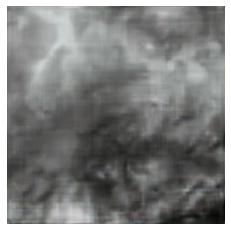

1/1 [==============================] - 0s 19ms/step


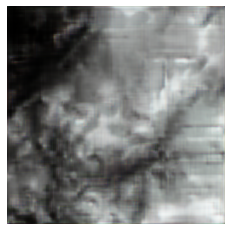

1/1 [==============================] - 0s 19ms/step


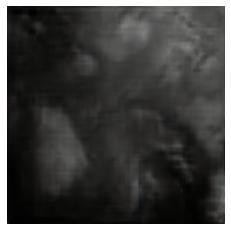

1/1 [==============================] - 0s 24ms/step


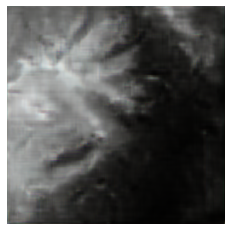

1/1 [==============================] - 0s 32ms/step


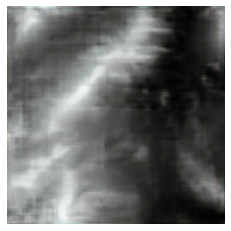

1/1 [==============================] - 0s 32ms/step


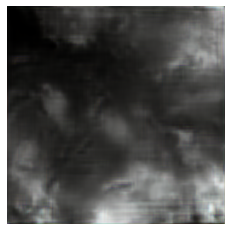

1/1 [==============================] - 0s 31ms/step


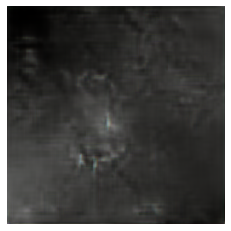

1/1 [==============================] - 0s 19ms/step


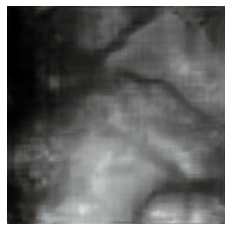

1/1 [==============================] - 0s 41ms/step


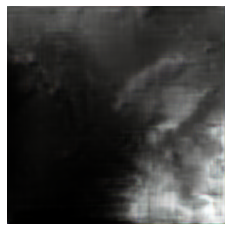

1/1 [==============================] - 0s 21ms/step


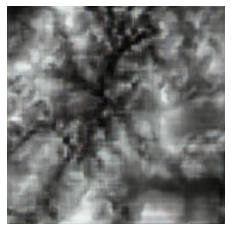

1/1 [==============================] - 0s 24ms/step


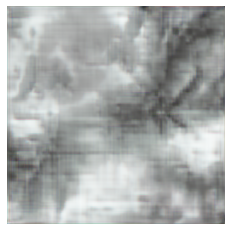

1/1 [==============================] - 0s 21ms/step


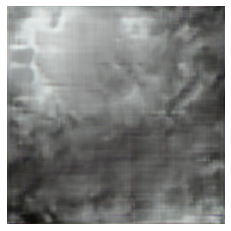

1/1 [==============================] - 0s 19ms/step


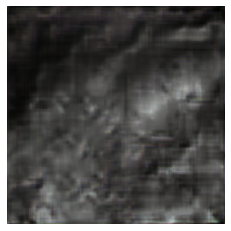

1/1 [==============================] - 0s 18ms/step


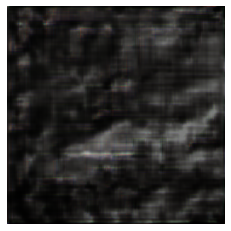

1/1 [==============================] - 0s 19ms/step


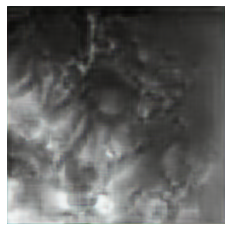

1/1 [==============================] - 0s 19ms/step


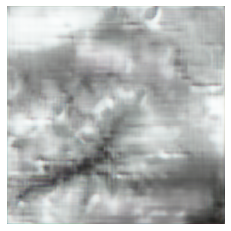

1/1 [==============================] - 0s 20ms/step


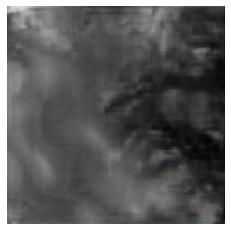

1/1 [==============================] - 0s 29ms/step


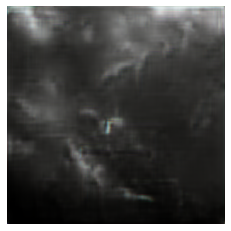

1/1 [==============================] - 0s 28ms/step


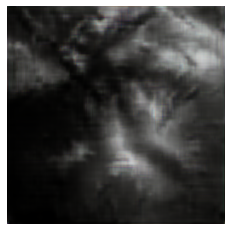

1/1 [==============================] - 0s 31ms/step


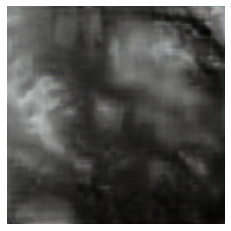

1/1 [==============================] - 0s 19ms/step


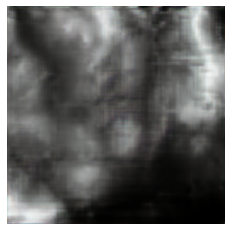

1/1 [==============================] - 0s 23ms/step


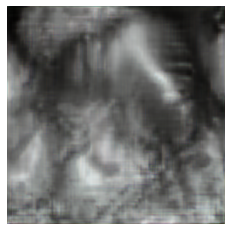

1/1 [==============================] - 0s 20ms/step


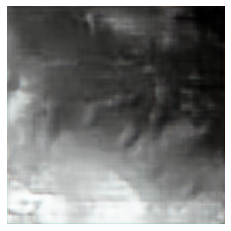

1/1 [==============================] - 0s 20ms/step


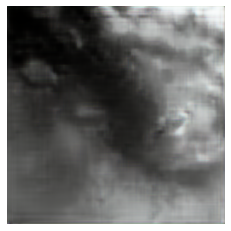

1/1 [==============================] - 0s 20ms/step


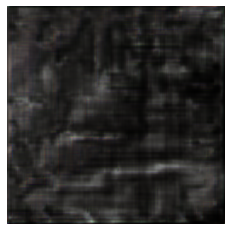

1/1 [==============================] - 0s 22ms/step


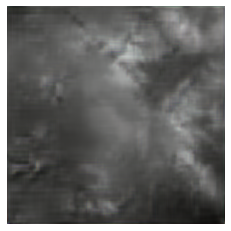

1/1 [==============================] - 0s 20ms/step


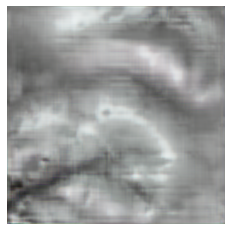

1/1 [==============================] - 0s 19ms/step


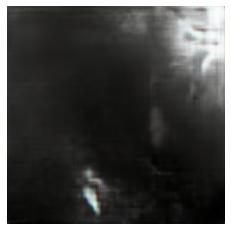

1/1 [==============================] - 0s 20ms/step


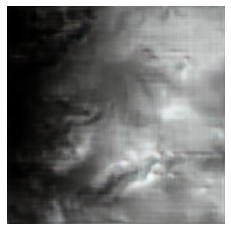

1/1 [==============================] - 0s 21ms/step


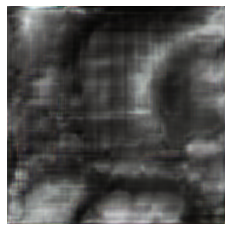

1/1 [==============================] - 0s 37ms/step


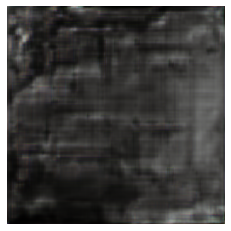

1/1 [==============================] - 0s 27ms/step


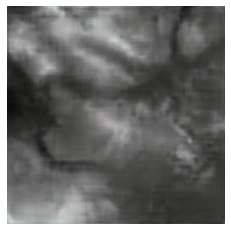

1/1 [==============================] - 0s 42ms/step


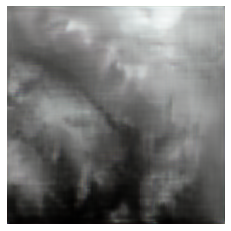

1/1 [==============================] - 0s 32ms/step


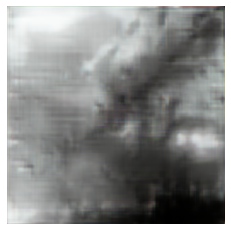

1/1 [==============================] - 0s 23ms/step


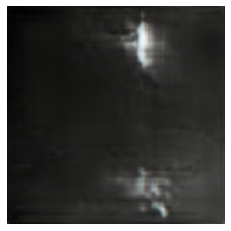

1/1 [==============================] - 0s 21ms/step


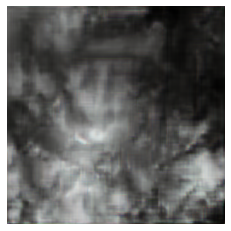

1/1 [==============================] - 0s 36ms/step


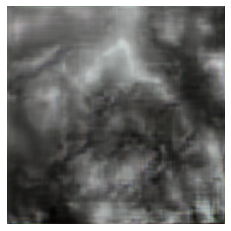

1/1 [==============================] - 0s 26ms/step


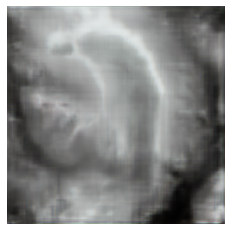

1/1 [==============================] - 0s 32ms/step


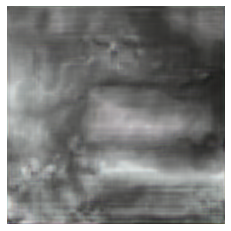

1/1 [==============================] - 0s 29ms/step


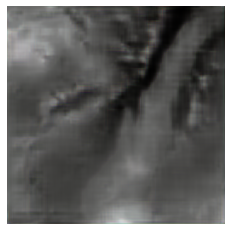

1/1 [==============================] - 0s 30ms/step


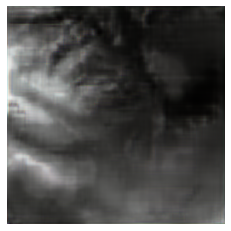

1/1 [==============================] - 0s 48ms/step


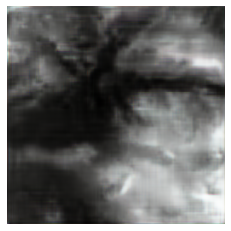

1/1 [==============================] - 0s 61ms/step


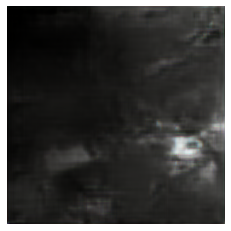

1/1 [==============================] - 0s 31ms/step


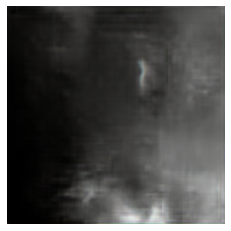

1/1 [==============================] - 0s 29ms/step


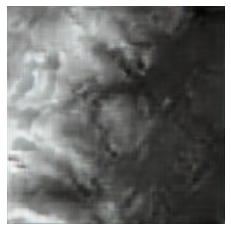

1/1 [==============================] - 0s 28ms/step


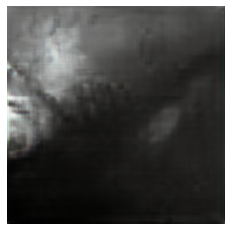

1/1 [==============================] - 0s 28ms/step


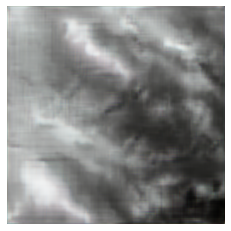

1/1 [==============================] - 0s 30ms/step


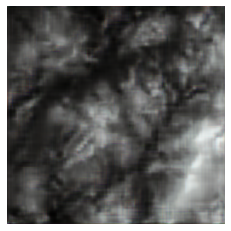

1/1 [==============================] - 0s 28ms/step


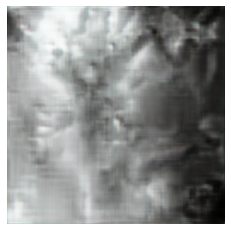

1/1 [==============================] - 0s 27ms/step


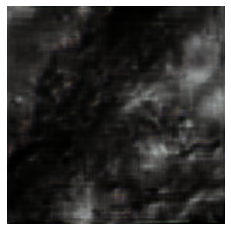

1/1 [==============================] - 0s 26ms/step


In [ ]:
# GENERATION OF MORE IMAGES
model = Model_GAN() 
model.load(65000) # The parameter refers to the number of training steps that has the model you want to load.

import matplotlib.pyplot as plt

for i in range(500):
    im2 = model.generator.predict(noise(1))
    if(i%10 == 0):
        plt.imshow(im2[0])
        plt.axis('off')
        plt.show()
    x = Image.fromarray(np.uint8(im2[0]*255)).convert('L')
    x.save(f'/content/drive/MyDrive/TFG/generated_GAN/gen_GAN_{i + 500}.png')